# <span style='background:Yellow'> Bottom Temp & Salt difference between SOSE and WOA

In [4]:
from dask.distributed import Client

client = Client("tcp://10.32.16.95:35191")
client

Client Scheduler: tcp://10.32.16.95:35191 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 19 Cores: 38 Memory: 218.50 GB


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
import geopandas
import scipy
import xesmf as xe

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [8]:
xr.set_options(display_style='text')

## <span style='color:Red'> Bottom temperature `SOSE - WOA` (1981-2010)

In [5]:
woa8110_pt = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_8110.nc')
sose_temp = xr.open_dataset('/home/jovyan/WMT/SOSE-budgets/bottom_temp.nc')

In [6]:
regridder = xe.Regridder(woa8110_pt, sose_temp, method='bilinear')
regridder

Overwrite existing file: bilinear_19x96_95x570.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_95x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (95, 570) 
Output grid dimension name: ('YC', 'XC') 
Periodic in longitude?      False

In [9]:
woa8110_pt_new_grid = regridder(woa8110_pt)
woa8110_pt_new_grid

using dimensions ('lat', 'lon') from data variable PT as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (XC: 570, YC: 95, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
    lat      (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
Dimensions without coordinates: XC, YC
Data variables:
    PT       (time, YC, XC) float64 0.0 0.0 0.0 nan ... -0.6926 -0.6907 -0.6888
Attributes:
    regrid_method:  bilinear

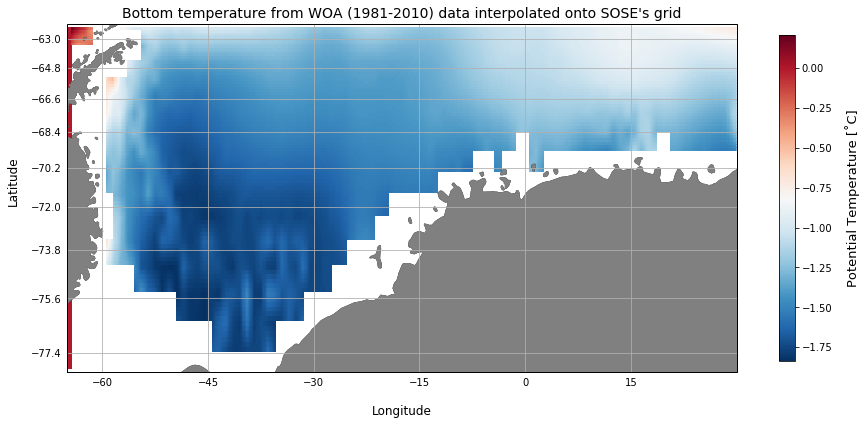

In [10]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa8110_pt_new_grid.lon, 
                   woa8110_pt_new_grid.lat, 
                   woa8110_pt_new_grid.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r')#, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (1981-2010) data interpolated onto SOSE's grid", fontsize=14);